# Setup

Dependencias: java>=11 & python>=3.8

Install java jdk 11

```bash
> apt-get install openjdk-11-jdk
```

Install python-terrier

```bash
> pip install python-terrier
```



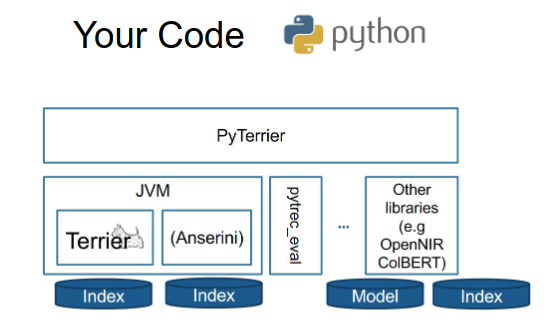

# Docs

https://pyterrier.readthedocs.io

# Usage

In [6]:
import pandas as pd
import pyterrier as pt
from pyterrier.index import IndexingType

if not pt.started():
  pt.init()

### Indexing

In [7]:
files = pt.io.find_files("../wiki-small")
files

['../wiki-small\\en\\articles\\(\\1\\5\\(15810)_1994_JR1_9064.html',
 '../wiki-small\\en\\articles\\0\\_\\(\\0_(number).html',
 '../wiki-small\\en\\articles\\1\\,\\5\\1,5-anhydro-D-fructose_reductase_0c7b.html',
 '../wiki-small\\en\\articles\\1\\0\\0\\100th_Anniversary_deb0.html',
 '../wiki-small\\en\\articles\\1\\0\\4\\10440_van_Swinden_fef9.html',
 '../wiki-small\\en\\articles\\1\\0\\7\\10769_Minas_Gerais_900d.html',
 '../wiki-small\\en\\articles\\1\\0\\9\\109P_Swift-Tuttle_8861.html',
 '../wiki-small\\en\\articles\\1\\1\\1\\1110s_BC_4367.html',
 '../wiki-small\\en\\articles\\1\\1\\2\\1127_Mimi_6c39.html',
 '../wiki-small\\en\\articles\\1\\1\\5\\1150.html',
 '../wiki-small\\en\\articles\\1\\1\\9\\119th_street_(Johnson_County)_56bd.html',
 '../wiki-small\\en\\articles\\1\\2\\2\\122_mm_howitzer_2A18_(D-30)_00d3.html',
 '../wiki-small\\en\\articles\\1\\2\\6\\12611_Ingres_7386.html',
 '../wiki-small\\en\\articles\\1\\3\\_\\13_(album).html',
 '../wiki-small\\en\\articles\\1\\4\\1\\1417_Wa

In [8]:
indexer = pt.FilesIndexer("./custom_trec_index", verbose=True, overwrite=True, type=IndexingType.MEMORY)
indexref = indexer.index(files)

In [9]:
# load the index, print the statistics
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 6043
Number of terms: 164940
Number of postings: 1689407
Number of fields: 0
Number of tokens: 3128731
Field names: []
Positions:   false



In [10]:
for kv in index.getLexicon():
  print("%s -> %s" % (kv.getKey(), kv.getValue().toString() ) )

0 -> term25 Nt=1072 TF=5945 maxTF=1 25
00 -> term1582 Nt=601 TF=1001 maxTF=1 1582
000 -> term2865 Nt=596 TF=1605 maxTF=1 2865
0001 -> term28345 Nt=1 TF=1 maxTF=1 28345
0002 -> term103931 Nt=1 TF=1 maxTF=1 103931
0003 -> term67768 Nt=4 TF=6 maxTF=1 67768
0004 -> term72387 Nt=2 TF=2 maxTF=1 72387
0006 -> term67767 Nt=1 TF=1 maxTF=1 67767
0008 -> term49835 Nt=1 TF=1 maxTF=1 49835
000m -> term83253 Nt=3 TF=3 maxTF=1 83253
000th -> term7838 Nt=2 TF=2 maxTF=1 7838
001 -> term50773 Nt=12 TF=14 maxTF=1 50773
0010 -> term67765 Nt=1 TF=1 maxTF=1 67765
0014 -> term124101 Nt=2 TF=3 maxTF=1 124101
0016 -> term8193 Nt=2 TF=2 maxTF=1 8193
0017 -> term144691 Nt=1 TF=1 maxTF=1 144691
0018 -> term67764 Nt=1 TF=2 maxTF=2 67764
002 -> term50325 Nt=8 TF=10 maxTF=1 50325
0021 -> term93256 Nt=2 TF=2 maxTF=1 93256
0022 -> term131091 Nt=1 TF=1 maxTF=1 131091
0027 -> term132765 Nt=1 TF=1 maxTF=1 132765
003 -> term16979 Nt=6 TF=6 maxTF=1 16979
0030 -> term19541 Nt=3 TF=3 maxTF=1 19541
004 -> term28299 Nt=11 TF=1

In [11]:
# indexar archivos en texto plano?
# ver: pyterrier.FilesIndexer
# https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html#pyterrier.FilesIndexer

### Retrieval

In [12]:
# ad-hoc retrieval
br = pt.BatchRetrieve(index, wmodel="TF_IDF") # wmodel="BM25", properties={"termpipelines" : "Stopwords,PorterStemmer"}
results = br.search("lata")
results

15:54:48.425 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


qid  docid  docno  rank     score query
0   1   5796  d5797     0  5.741787  lata
1   1   4202  d4203     1  4.994493  lata
2   1   1254  d1255     2  2.124574  lata
3   1   4320  d4321     3  1.593414  lata

In [13]:
# batch retrieval

# define topics (queries) and qrels (relevance judgments)

topics = pd.DataFrame([["1", "casa tero"], ["2", "lata"]], columns=["qid", "query"])
qrels = pd.DataFrame([["1", "1", 2], ["1", "2", 1], ["2", "3", 1], ["2", "4", 2]], columns=["qid", "docno", "label"])

In [14]:
topics

qid      query
0   1  casa tero
1   2       lata

In [15]:
qrels

qid docno  label
0   1     1      2
1   1     2      1
2   2     3      1
3   2     4      2

In [16]:
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
pt.Experiment([tf_idf, bm25], topics, qrels, eval_metrics=["map", "ndcg", "recall_3"])
# available measures: https://pyterrier.readthedocs.io/en/latest/experiments.html#available-evaluation-measures

15:54:54.407 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
15:54:54.415 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


name  map  ndcg  recall_3
0  BR(TF_IDF)  0.0   0.0       0.0
1    BR(BM25)  0.0   0.0       0.0

In [17]:
pt.Experiment([tf_idf, bm25], topics, qrels, eval_metrics=["map", "ndcg", "recall_2"], perquery=True)

name qid   measure  value
6     BR(BM25)   1       map    0.0
7     BR(BM25)   1  recall_2    0.0
8     BR(BM25)   1      ndcg    0.0
9     BR(BM25)   2       map    0.0
10    BR(BM25)   2  recall_2    0.0
11    BR(BM25)   2      ndcg    0.0
0   BR(TF_IDF)   1       map    0.0
1   BR(TF_IDF)   1  recall_2    0.0
2   BR(TF_IDF)   1      ndcg    0.0
3   BR(TF_IDF)   2       map    0.0
4   BR(TF_IDF)   2  recall_2    0.0
5   BR(TF_IDF)   2      ndcg    0.0

###  Use standard collections

In [18]:
pt.datasets.list_datasets()

[INFO] trec-robust04 is deprecated. Consider using disks45/nocr/trec-robust-2004 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold1 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold1 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold2 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold2 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold3 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold3 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold4 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold4 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold5 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold5 instead, which provides better parsing of the corpus.
[INFO] acessing TREC Fair Ranking 2021 through trec-fair-2021 is deprecated; use trec-fair/2021 instead.
[INFO] acessing TREC Fair

dataset  \
0                          50pct   
1                        antique   
2                        vaswani   
3               msmarco_document   
4             msmarcov2_document   
..                           ...   
746                 irds:neuclir   
747               irds:neuclir/1   
754                    irds:sara   
755      trec-deep-learning-docs   
756  trec-deep-learning-passages   

                                                topics topics_lang  \
0                               [training, validation]          en   
1                                        [train, test]          en   
2                                                 True          en   
3      [train, dev, test, test-2020, leaderboard-2020]          en   
4       [train, dev1, dev2, valid1, valid2, trec_2021]          en   
..                                                 ...         ...   
746                                               None        None   
747                                               None        None   
754                                               True          en   
755    [train, dev, test, test-2020, leaderboard-2020]          en   
756  [train, dev, dev.small, eval, eval.small, test...          en   

                                             qrels corpus corpus_lang  \
0                           [training, validation]   None        None   
1                                    [train, test]   True          en   
2                                             True   True          en   
3                    [train, dev, test, test-2020]   True          en   
4              [train, dev1, dev2, valid1, valid2]   None        None   
..                                             ...    ...         ...   
746                                           None   None        None   
747                                           None   None        None   
754                                           True   True          en   
755                  [train, dev, test, test-2020]   True          en   
756  [train, dev, test-2019, test-2020, dev.small]   True          en   

          index                                           info_url  
0    [ex2, ex3]                                               None  
1          None  https://ciir.cs.umass.edu/downloads/Antique/re...  
2          True  http://ir.dcs.gla.ac.uk/resources/test_collect...  
3          True               https://microsoft.github.io/msmarco/  
4          True  https://microsoft.github.io/msmarco/TREC-Deep-...  
..          ...                                                ...  
746        None               https://ir-datasets.com/neuclir.html  
747        None     https://ir-datasets.com/neuclir.html#neuclir/1  
754        None                  https://ir-datasets.com/sara.html  
755        True               https://microsoft.github.io/msmarco/  
756        True  https://microsoft.github.io/MSMARCO-Passage-Ra...  

[437 rows x 8 columns]

In [19]:
dataset = pt.get_dataset("vaswani")
# "terrier_stemmed" - a classical index, removing Terrier’s standard stopwords, and applying Porter’s English stemmer

In [20]:
dataset.get_topics()

15:54:54.510 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8


qid                                              query
0    1  measurement of dielectric constant of liquids ...
1    2  mathematical analysis and design details of wa...
2    3  use of digital computers in the design of band...
3    4    systems of data coding for information transfer
4    5  use of programs in engineering testing of comp...
..  ..                                                ...
88  89  tunnel diode construction and its electrical c...
89  90  electronic density of states at the surface of...
90  91  resistivity of metallic thin films related to ...
91  92  the phenomenon of radiation caused by charged ...
92  93  high frequency oscillators using transistors t...

[93 rows x 2 columns]

In [21]:
dataset.get_qrels()

qid  docno  label
0      1   1239      1
1      1   1502      1
2      1   4462      1
3      1   4569      1
4      1   5472      1
...   ..    ...    ...
2078  93   9875      1
2079  93   9956      1
2080  93  10497      1
2081  93  11191      1
2082  93  11318      1

[2083 rows x 3 columns]

In [22]:
tf = pt.BatchRetrieve(dataset.get_index(), wmodel="Tf")
tfidf = pt.BatchRetrieve(dataset.get_index(), wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(dataset.get_index(), wmodel="BM25")

results = pt.Experiment(
    [tf, tfidf, bm25],
    dataset.get_topics(),
    dataset.get_qrels(),
    eval_metrics=["recall"]
)
results

15:54:54.684 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8


name       R@5      R@10      R@15      R@20      R@30     R@100  \
0      BR(Tf)  0.066489  0.114427  0.155294  0.177110  0.239787  0.425632   
1  BR(TF_IDF)  0.162330  0.220588  0.266475  0.299181  0.368710  0.597182   
2    BR(BM25)  0.162592  0.218513  0.260196  0.300136  0.374032  0.599046   

      R@200     R@500    R@1000  
0  0.581683  0.782172  0.902832  
1  0.737240  0.866759  0.934214  
2  0.732080  0.867562  0.934607

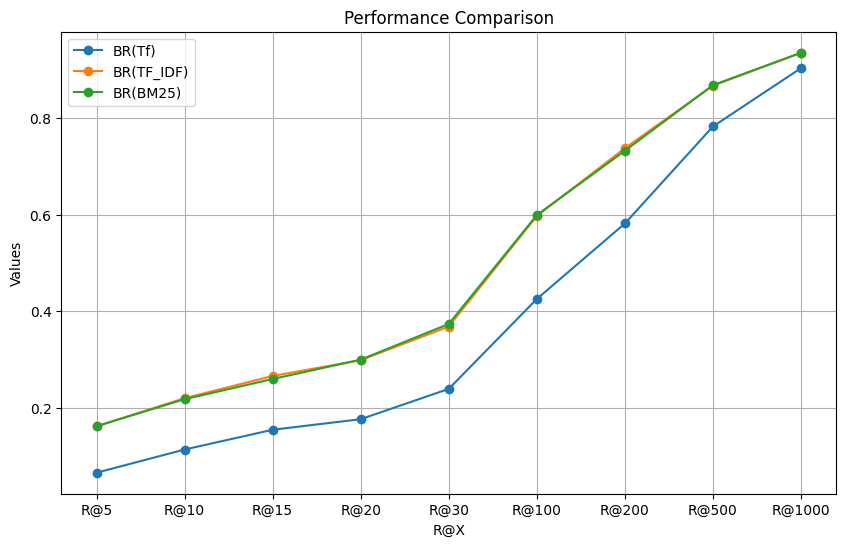

In [23]:
import matplotlib.pyplot as plt
results.set_index('name', inplace=True)
df_t = results.T
plt.figure(figsize=(10, 6))
for column in df_t.columns:
    plt.plot(df_t.index, df_t[column], marker='o', label=column)

plt.title('Performance Comparison')
plt.xlabel('R@X')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()